Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Load & Preprocess MNIST

In [2]:
# Load MNIST (70k images, 28x28)
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# Normalize to [0,1]
X = X / 255.0

# Take a subset for speed (e.g., 10000 samples)
X, _, y, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False, categories="auto")
y_train_oh = encoder.fit_transform(y_train.reshape(-1,1))
y_val_oh   = encoder.transform(y_val.reshape(-1,1))

print("Train:", X_train.shape, y_train_oh.shape)
print("Val:", X_val.shape, y_val_oh.shape)


Train: (8000, 784) (8000, 10)
Val: (2000, 784) (2000, 10)


Define Neural Network (2 layers)

In [4]:
class TwoLayerNN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        # Xavier init
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr
        self.losses = []

    # Activation
    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    # Forward
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    # Loss
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        eps = 1e-8
        #Cross entropy
        return -np.sum(y_true * np.log(y_pred + eps)) / m

    # Backward
    def backward(self, X, y_true, y_pred):
        m = X.shape[0]

        dz2 = y_pred - y_true
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.W2.T) * self.relu_deriv(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Gradient descent update
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    # Training step
    def train(self, X, y, X_val, y_val, epochs=50, batch_size=64):
        m = X.shape[0]
        for epoch in range(epochs):
            # Shuffle
            idx = np.random.permutation(m)
            X, y = X[idx], y[idx]

            for i in range(0, m, batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_batch, y_pred)
                self.backward(X_batch, y_batch, y_pred)

            # Track val loss
            y_val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, y_val_pred)
            self.losses.append(val_loss)

            if epoch % 5 == 0:
                acc = self.accuracy(y_val, y_val_pred)
                print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_acc={acc:.4f}")

    # Prediction
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, y_true, y_pred_probs):
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred_probs, axis=1)
        return np.mean(y_true_labels == y_pred_labels)


Traain on MNIST

In [5]:
model = TwoLayerNN(input_dim=784, hidden_dim=128, output_dim=10, lr=0.1)
model.train(X_train, y_train_oh, X_val, y_val_oh, epochs=50, batch_size=128)


Epoch 0: val_loss=0.6474, val_acc=0.8605
Epoch 5: val_loss=0.3517, val_acc=0.8970
Epoch 10: val_loss=0.3000, val_acc=0.9110
Epoch 15: val_loss=0.2720, val_acc=0.9175
Epoch 20: val_loss=0.2578, val_acc=0.9220
Epoch 25: val_loss=0.2414, val_acc=0.9245
Epoch 30: val_loss=0.2347, val_acc=0.9290
Epoch 35: val_loss=0.2252, val_acc=0.9320
Epoch 40: val_loss=0.2206, val_acc=0.9315
Epoch 45: val_loss=0.2205, val_acc=0.9365


✅ Final Validation Accuracy: 0.937


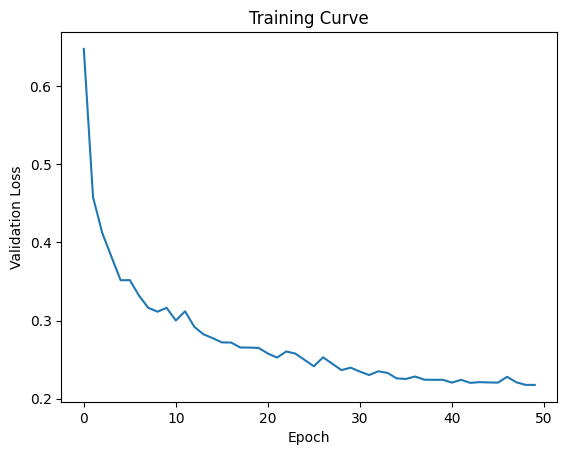

In [6]:
y_val_pred = model.predict(X_val)
val_acc = np.mean(y_val_pred == y_val)
print("✅ Final Validation Accuracy:", val_acc)

# Plot loss curve
plt.plot(model.losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Training Curve")
plt.show()
